In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime
from torchsummary import summary

In [2]:
# Find normalization parameters for CIFAR10

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
data = torch.tensor(trainset.data, dtype=torch.float32, device=device) / 255
print(data.shape)  # torch.Size([50000, 32, 32, 3])
mean = data.mean(dim=(0, 1, 2))
std = data.std(dim=(0, 1, 2))

Files already downloaded and verified
torch.Size([50000, 32, 32, 3])


In [3]:
# augumentacja
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # Zmiana jasności, kontrastu, nasycenia, itd.
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        # Losowe odbicie lustrzane
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize(mean=mean, std=std),
    ]
)

BATCH_SIZE = 128

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
)

test_set = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]
    ),
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

classes = trainset.classes
print(classes)

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
def show_img(img):
    plt.figure(figsize=(15, 15))
    img = img * std.to("cpu").view(3, 1, 1) + mean.to("cpu").view(
        3, 1, 1
    )  # denormalize
    img = img.to("cpu").numpy()
    plt.imshow(
        np.transpose(img, (1, 2, 0))
    )  # imshow requires (32, 32, 3) instead of (3, 32, 32)
    plt.show()

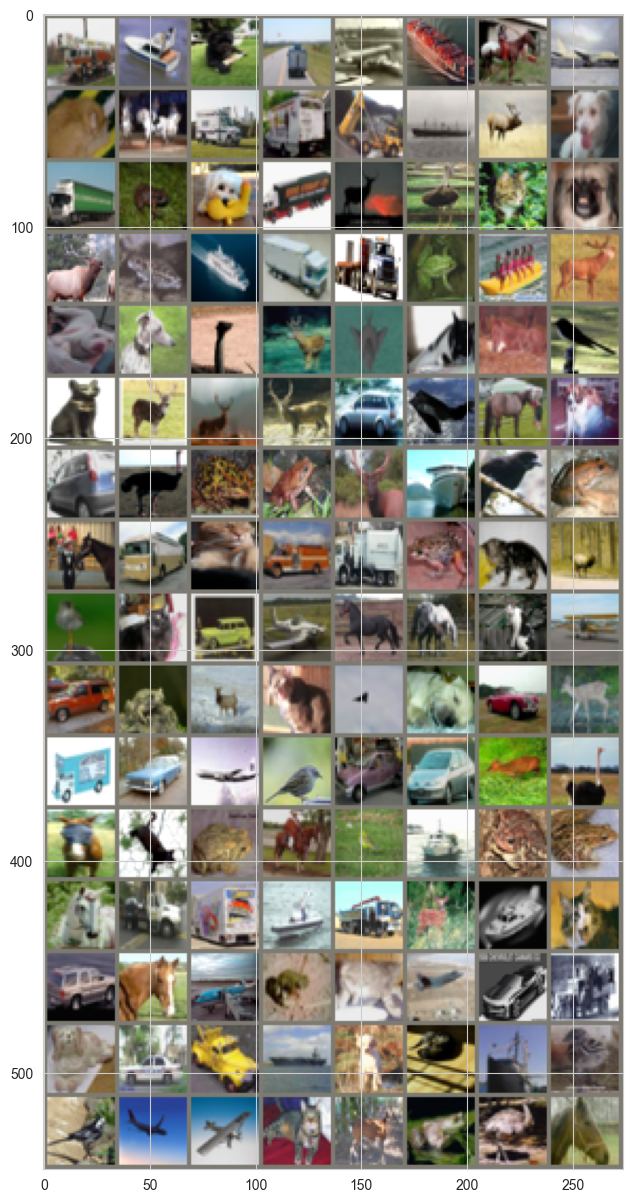

In [5]:
dataiter = iter(train_loader)
images, _ = next(dataiter)
images = [image.to("cpu") for image in images]
show_img(torchvision.utils.make_grid(images))

Wzór na wielkość wyjścia z konwolucji:
$
\text{Output size} = \frac{\text{Input size} - \text{Kernel size} + 2 \times \text{Padding}}{\text{Stride}} + 1
$

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(
            in_channels=3,  # RGB
            out_channels=6,
            kernel_size=5,
            stride=1,
            padding=0,
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_2 = nn.Conv2d(
            in_channels=self.conv_1.out_channels,  # 6
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=0,
        )

        # na wejściu 3x32x32
        # po pierwszej konwolucji 6x28x28
        # po pierwszym poolingu 6x14x14
        # po drugiej konwolucji 16x10x10
        # po drugim poolingu 16x5x5
        self.fully_connected_1 = nn.Linear(
            in_features=self.conv_2.out_channels * 5 * 5,  # 16*5*5
            out_features=120,
        )
        self.fully_connected_2 = nn.Linear(
            in_features=self.fully_connected_1.out_features,  # 120
            out_features=84,
        )
        self.fully_connected_3 = nn.Linear(
            in_features=self.fully_connected_2.out_features,  # 84
            out_features=10,  # 10 klas
        )

    def forward(self, x):
        x = self.pool(F.relu(self.conv_1(x)))
        x = self.pool(F.relu(self.conv_2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fully_connected_1(x))
        x = F.relu(self.fully_connected_2(x))
        x = self.fully_connected_3(x)
        return x


model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_accuracy = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, accuracy, model):
        if accuracy > self.best_accuracy:
            if self.counter > 0:
                print(
                    f"Accuracy increased ({self.best_accuracy:.3f} --> {accuracy:.3f}). Resetting early stopping counter."
                )
            self.best_accuracy = accuracy
            self.counter = 0
            self.best_model_state = model.state_dict()
        else:
            self.counter += 1
            print(f"Early stopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [8]:
EPOCHS = 100
early_stopping = EarlyStopping(patience=5)
train_acc_history = []
test_acc_history = []
last_time = datetime.now()

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for input, labels in train_loader:
        input, labels = input.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_acc = 100.0 * correct_train / total_train
    train_acc_history.append(train_acc)

    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for input, labels in test_loader:
            input, labels = input.to(device), labels.to(device)
            output = model(input)
            _, predicted = output.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_acc = 100.0 * correct_test / total_test
    test_acc_history.append(test_acc)

    new_time = datetime.now()
    new_time_str = new_time.strftime("%H:%M:%S")
    took_time_str = (new_time - last_time).total_seconds()
    print(
        f"({new_time_str}) Epoch [{epoch + 1}/{EPOCHS}], Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%, Took: {took_time_str:.2f}s"
    )
    last_time = new_time

    early_stopping(test_acc, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

(14:31:25) Epoch [1/100], Loss: 670.5060, Train Accuracy: 37.35%, Test Accuracy: 46.01%, Took: 46.38s
(14:32:05) Epoch [2/100], Loss: 555.3504, Train Accuracy: 49.23%, Test Accuracy: 51.42%, Took: 40.23s
(14:33:23) Epoch [3/100], Loss: 515.0771, Train Accuracy: 53.20%, Test Accuracy: 53.97%, Took: 77.82s
(14:34:28) Epoch [4/100], Loss: 480.2020, Train Accuracy: 56.49%, Test Accuracy: 57.86%, Took: 64.84s
(14:35:20) Epoch [5/100], Loss: 458.0093, Train Accuracy: 58.38%, Test Accuracy: 58.59%, Took: 52.14s
(14:36:11) Epoch [6/100], Loss: 440.5086, Train Accuracy: 60.21%, Test Accuracy: 61.13%, Took: 51.09s
(14:37:00) Epoch [7/100], Loss: 423.4909, Train Accuracy: 61.48%, Test Accuracy: 61.27%, Took: 49.52s
(14:37:50) Epoch [8/100], Loss: 410.9201, Train Accuracy: 62.77%, Test Accuracy: 62.26%, Took: 49.76s
(14:38:41) Epoch [9/100], Loss: 397.6195, Train Accuracy: 64.04%, Test Accuracy: 62.81%, Took: 50.32s
(14:39:31) Epoch [10/100], Loss: 387.1437, Train Accuracy: 65.10%, Test Accuracy: 

In [9]:
del model
model = CNN().to(device)
model.load_state_dict(early_stopping.best_model_state)
timestamp = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
torch.save(model.state_dict(), f"model_{timestamp}.pth")

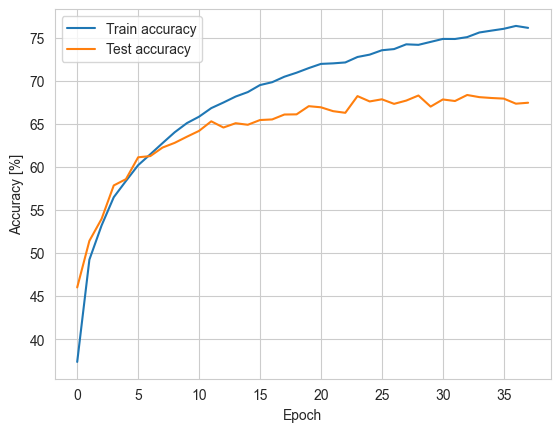

In [10]:
plt.plot(train_acc_history, label="Train accuracy")
plt.plot(test_acc_history, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.legend()
plt.show()

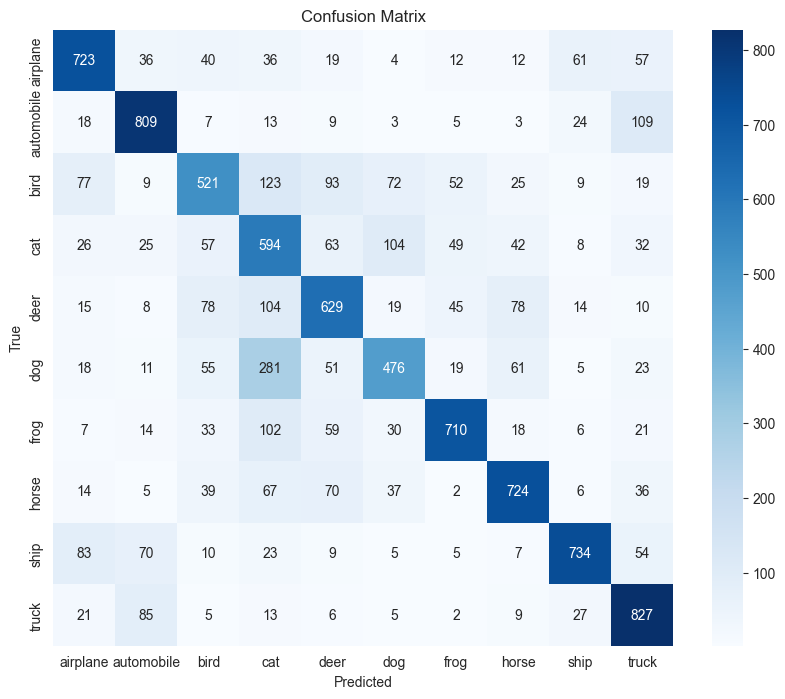

In [11]:
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [12]:
summary(model, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           456
├─MaxPool2d: 1-2                         [-1, 6, 14, 14]           --
├─Conv2d: 1-3                            [-1, 16, 10, 10]          2,416
├─MaxPool2d: 1-4                         [-1, 16, 5, 5]            --
├─Linear: 1-5                            [-1, 120]                 48,120
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 10]                  850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (M): 0.65
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           456
├─MaxPool2d: 1-2                         [-1, 6, 14, 14]           --
├─Conv2d: 1-3                            [-1, 16, 10, 10]          2,416
├─MaxPool2d: 1-4                         [-1, 16, 5, 5]            --
├─Linear: 1-5                            [-1, 120]                 48,120
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 10]                  850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (M): 0.65
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30